In [29]:
%load_ext autoreload
%autoreload 2

import os

subj = "Subj3"

UNIQUE_VALUES_THRESHOLD = 200

exp = "exp_shuffled"
os.makedirs(f"{subj}/{exp}", exist_ok = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import mne
import numpy
import pandas
import sklearn.metrics
import sklearn.preprocessing
import sklearn.decomposition

import SDA.topology
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

### Data

In [31]:
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")# .drop_channels(ch_names = [ 'IVEOG', 'IHEOG' ])
N_STAGES = int(numpy.loadtxt(f"{subj}/src/n_stages.txt"))
print('Stages: ', N_STAGES)

# epochs.average().plot_joint().savefig(f"{subj}/{exp}/eeg.svg")
data = epochs.get_data(copy = True)
print(data.shape)

Reading d:\HSE\year-3\HSE\CourseProject\Subj3\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1180 matching events found
No baseline correction applied
0 projection items activated
Stages:  10
(1180, 40, 501)


In [32]:
numpy.random.seed(42)
shuffle_order = numpy.load(f"{subj}/{exp}/shuffle_order.npy")
data = data[shuffle_order]

In [33]:
shuffle_order

array([ 210,   58,  943, ..., 1130,  860, 1126], dtype=int64)

### Features

In [34]:
features = numpy.load(f"{subj}/{exp}/qsda/best_features.npy")
features.shape

(1180, 19563)

### Results

#### Estimator

In [35]:
def analyze(all_features: pandas.DataFrame, n_components: int, folder: str):
    folder = f"{subj}/{exp}/results/{folder}"
    os.makedirs(folder, exist_ok = True)

    # Scale features
    all_features = sklearn.preprocessing.StandardScaler().fit_transform(all_features)
    print(all_features.shape)
    numpy.save(f"{folder}/all_features.npy", all_features)
    numpy.savetxt(f"{folder}/all_features_shape.txt", all_features.shape)

    # PCA
    pca = sklearn.decomposition.PCA(n_components = n_components, svd_solver = "full", random_state = 42)
    pca_features = pca.fit_transform(all_features)
    print(pca_features.shape)
    numpy.save(f"{folder}/pca_features.npy", pca_features)
    numpy.savetxt(f"{folder}/pca_features_shape.txt", pca_features.shape)
    
    print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
    print([ round(x, 3) for x in pca.explained_variance_ratio_ ])
    numpy.savetxt(f"{folder}/explained_variance.txt", [ pca.explained_variance_ratio_.sum() ])
    numpy.savetxt(f"{folder}/explained_variance_ratios.txt", pca.explained_variance_ratio_)

    # SDA
    sda = SDA.SDA(n_jobs = 14, scale = False, verbose = True)
    results, df_st_edges = sda.apply(pca_features)
    
    results.to_csv(f"{folder}/results.csv")
    df_st_edges.to_csv(f"{folder}/df_st_edges.csv")

    # Analyze
    best_results = SDA.analytics.best_results(results, key = 'Avg-Silh')
    best_results.to_csv(f"{folder}/best_results.csv")
    
    best_result = SDA.analytics.best_result(results, key = 'Avg-Silh', n_stages = N_STAGES)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_stats(pca_features, epochs, best_result, df_st_edges).savefig(f"{folder}/stats.svg")

#### Традиционные признаки

(1180, 765)
(1180, 15)
Explained variance 0.72
[0.323, 0.095, 0.07, 0.043, 0.032, 0.025, 0.023, 0.02, 0.018, 0.016, 0.014, 0.012, 0.011, 0.01, 0.009]
Applying to 1180 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:10<00:00, 64.23it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,40,40,10,Mode,40,"[0, 67, 113, 160, 215, 555, 670, 865, 999, 112...",10,340,46,118.0,1722.441551,6.006393,-0.096988,2.28688,19.435976,0.017023,3.266005,9.78198


array([   0,   67,  113,  160,  215,  555,  670,  865,  999, 1122, 1180])

,0,1,2,3,4,5,6,7,8,9
"Start-end time, sec","(8.5, 80.5)","(81.5, 126.5)","(127.5, 180.5)","(181.5, 242.5)","(243.5, 628.5)","(629.5, 755.5)","(756.5, 965.5)","(967.5, 1112.5)","(1113.5, 1243.5)","(1244.5, 1304.5)"
"Time length, sec",72.0,45.0,53.0,61.0,385.0,126.0,209.0,145.0,130.0,60.0
Number of epochs,67,46,47,55,340,115,195,134,123,58


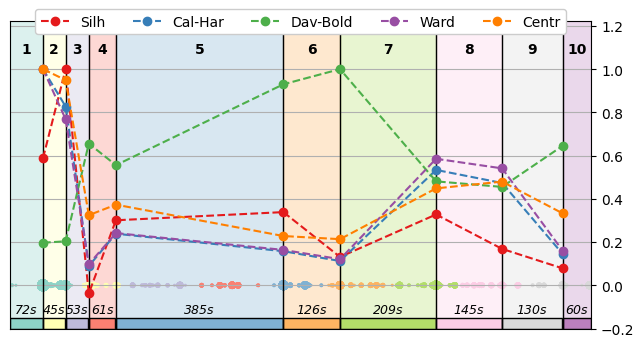

In [36]:
def read_traditional():
    df_ft_psd_loc_db = pandas.read_feather(f'{subj}/src/df_ft_psd_loc_db.feather')
    df_ft_psd_ind_loc_log = pandas.read_feather(f'{subj}/src/df_ft_psd_ind_loc_log.feather')
    df_ft_coh_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_coh_ind_loc.feather')
    df_ft_plv_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_plv_ind_loc.feather')

    result =  pandas.concat([
        df_ft_psd_loc_db,
        df_ft_psd_ind_loc_log,
        df_ft_coh_ind_loc,
        df_ft_plv_ind_loc
    ], axis = 1)

    if subj == "Subj2":
        result = result # [:-2]
    return result.to_numpy()[shuffle_order]

analyze(read_traditional(), 15, "traditional")

#### Топологические признаки + QSDA + PCA

(1180, 19563)
(1180, 15)
Explained variance 0.27
[0.095, 0.049, 0.02, 0.012, 0.011, 0.01, 0.01, 0.009, 0.009, 0.008, 0.008, 0.007, 0.007, 0.007, 0.006]
Applying to 1180 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:09<00:00, 68.02it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,0,35,20,Mode,40,"[0, 105, 238, 306, 369, 427, 685, 856, 899, 94...",10,258,42,118.0,5744.597101,12.012988,-0.052925,1.088491,18.706479,0.005024,1.225266,12.070017


array([   0,  105,  238,  306,  369,  427,  685,  856,  899,  941, 1180])

,0,1,2,3,4,5,6,7,8,9
"Start-end time, sec","(8.5, 118.5)","(119.5, 269.5)","(270.5, 344.5)","(345.5, 416.5)","(417.5, 482.5)","(483.5, 771.5)","(772.5, 954.5)","(955.5, 1003.5)","(1004.5, 1049.5)","(1050.5, 1304.5)"
"Time length, sec",110.0,150.0,74.0,71.0,65.0,288.0,182.0,48.0,45.0,254.0
Number of epochs,105,133,68,63,58,258,171,43,42,239


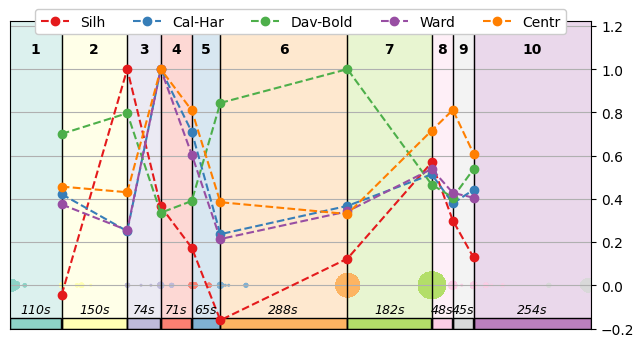

In [37]:
analyze(features, 15, "best_topological")

#### Традиционные и топологические вместе + PCA

(1180, 20328)
(1180, 15)
Explained variance 0.28
[0.093, 0.058, 0.02, 0.013, 0.011, 0.01, 0.01, 0.009, 0.009, 0.008, 0.008, 0.007, 0.007, 0.006, 0.006]
Applying to 1180 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:09<00:00, 68.89it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,40,40,15,Mode,40,"[0, 122, 164, 306, 374, 482, 685, 791, 857, 97...",10,203,42,118.0,7150.845667,12.040336,-0.046431,1.267418,20.416383,0.004801,1.459459,11.749799


array([   0,  122,  164,  306,  374,  482,  685,  791,  857,  978, 1180])

,0,1,2,3,4,5,6,7,8,9
"Start-end time, sec","(8.5, 135.5)","(137.5, 184.5)","(186.5, 344.5)","(345.5, 421.5)","(422.5, 549.5)","(550.5, 771.5)","(772.5, 887.5)","(888.5, 955.5)","(957.5, 1089.5)","(1090.5, 1304.5)"
"Time length, sec",127.0,47.0,158.0,76.0,127.0,221.0,115.0,67.0,132.0,214.0
Number of epochs,122,42,142,68,108,203,106,66,121,202


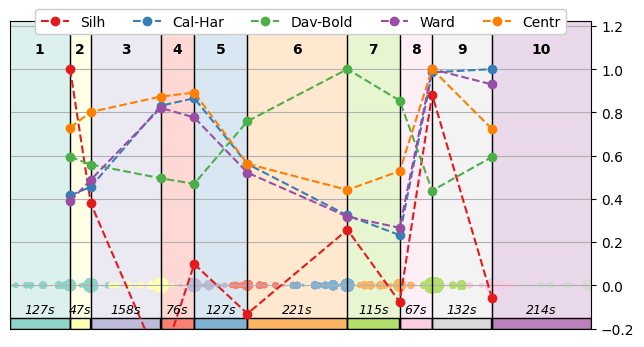

In [38]:
combined_features = numpy.concatenate([ read_traditional(), features ], axis = 1)
analyze(combined_features, 15, "combined")